# Generate multiple plots about Kr data

### Notebook configuration

In [1]:
run_number          = 4734
correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
dst_filename        = f"$IC_DATA/Kr/dst_{run_number}_filtered.root.h5"
plots_output_folder = f"plots/{run_number}/"

XY_pitch            = 5.0

Zrange              =     0, 560
XYrange             =  -200, 200
Rrange              =     0, max(XYrange)
Phirange            = -3.14, 3.14

Erange              =  33.5, 49.5
Qrange              =     0, 1200
QErange             =     0, Qrange[1]/Erange[1]

S1Erange            =     0, 40
S1Wrange            =     0, 500
S1Hrange            =     0, 10

S2Erange            =     0, 15e3
S2Wrange            =     0, 50
S2Hrange            =     0, 10e3
NSirange            =     0, 80

Zrange_DV           =   500, 600
Zrange_LT           =    50, 520
Zrange_XY           =     0, 520

XYnbins             =  50
Znbins              = 100
Rnbins              = 100
Phinbins            = 100
Enbins              = 200
Qnbins              = 200

S1Enbins            = 40
S1Wnbins            = 20
S1Hnbins            = 50

S2Enbins            = 100
S2Wnbins            = 50
S2Hnbins            = 80
NSinbins            = 80

DVnbins             = 50

R_fiducial          =  80
Z_fiducial          = 100

# Plotting style
default_cmap        = "jet"
figure_size         = 16, 12
font_size           = 20
global_linewidth    = 4
subfit_linewidth    = 4
global_linecolor    = "r"
subfit_linecolor    = "m g b y".split()
subfit_linecolor    = "b m slategrey c b y".split()

save_plots          = False
with_titles         = False
plots_format        = "pdf"

### Imports

In [2]:
import os
import time
import collections
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.database.load_db        as DB
import invisible_cities.core    .core_functions as coref
import invisible_cities.core    .fit_functions  as fitf
import invisible_cities.reco    .corrections    as corrf
import invisible_cities.reco    .dst_functions  as dstf

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import pdf
from invisible_cities.icaro.hst_functions import display_matrix
from invisible_cities.icaro.hst_functions import resolution
from invisible_cities.icaro.hst_functions import poisson_sigma
from invisible_cities.icaro.hst_functions import gausstext
from invisible_cities.icaro.hst_functions import shift_to_bin_centers
from invisible_cities.icaro.hst_functions import plot_writer
from invisible_cities.icaro.hst_functions import measurement_string

from icaro.core.fit_functions import conditional_labels

Running on  Tue Nov 21 16:22:04 2017


### Initialization

In [3]:
save   = plot_writer(plots_output_folder, plots_format) if save_plots else lambda *x: None
labels = conditional_labels(with_titles)

In [4]:
%matplotlib inline

plt.rcParams["figure.figsize"         ] = figure_size
plt.rcParams[  "font.size"            ] =   font_size
plt.rcParams["figure.max_open_warning"] = 1000

In [5]:
Zbins     = np.linspace(*  Zrange   ,   Znbins + 1)
Ebins     = np.linspace(*  Erange   ,   Enbins + 1)
Qbins     = np.linspace(*  Qrange   ,   Qnbins + 1)

S1Ebins   = np.linspace(*S1Erange   , S1Enbins + 1)
S1Wbins   = np.linspace(*S1Wrange   , S1Wnbins + 1)
S1Hbins   = np.linspace(*S1Hrange   , S1Hnbins + 1)

S2Ebins   = np.linspace(*S2Erange   , S2Enbins + 1)
S2Wbins   = np.linspace(*S2Wrange   , S2Wnbins + 1)
S2Hbins   = np.linspace(*S2Hrange   , S2Hnbins + 1)
NSibins   = np.linspace(*NSirange   , NSinbins + 1)

XYbins    = np.linspace(* XYrange   ,  XYnbins + 1)
Rbins     = np.linspace(*  Rrange   ,   Rnbins + 1)
Phibins   = np.linspace(*Phirange   , Phinbins + 1)
DVbins    = np.linspace(*  Zrange_DV,  DVnbins + 1)

dst_filename        = os.path.expandvars(       dst_filename)
correction_filename = os.path.expandvars(correction_filename)

### Read data

In [6]:
dst = dstf.load_dst(dst_filename, "DST", "Events")
dst = dst[dst.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(dst))
dst.head()

971540


,index,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,0,6,1.507368e+09,0,1,150.0,0.918589,5.302018,260975.0,10.7625,...,654500.0,32,393.525,393.525,110.109160,76.577461,134.119852,0.607678,13.281222,12.380607
1,1,8,1.507368e+09,0,1,125.0,1.663614,7.505072,311675.0,10.4875,...,654500.0,31,342.825,342.825,-84.927306,42.502615,94.969045,2.677578,12.633615,15.235298
2,3,12,1.507368e+09,0,1,225.0,2.741303,17.944131,209450.0,10.8625,...,653500.0,29,444.050,444.050,-34.455078,145.627975,149.648453,1.803121,12.388186,25.229376
3,5,17,1.507368e+09,0,1,200.0,1.953479,9.259772,240275.0,11.4375,...,654500.0,29,414.225,414.225,81.499882,-74.629563,110.507025,-0.741423,25.768544,12.567276
4,6,18,1.507368e+09,0,1,300.0,5.919568,32.076883,269525.0,10.6625,...,653500.0,34,383.975,383.975,15.658394,-195.197920,195.824955,-1.490750,20.252646,26.597081


In [8]:
LT_correction  = dstf.load_lifetime_xy_corrections(correction_filename,
                                                   group = "XYcorrections",
                                                   node  = "Lifetime")

GEO_correction = dstf.load_xy_corrections(correction_filename,
                                          group         =  "XYcorrections",
                                          node          = f"GeometryE_{XY_pitch:.1f}mm",
                                          norm_strategy =  "index",
                                          norm_opts     = {"index": (40, 40)})

In [9]:
evt = dst.event.values
T   =(dst.time .values -
      dst.time.values.min()) / 60
S2n = dst.nS2  .values

S1e = dst.S1e.values
S1w = dst.S1w.values
S1h = dst.S1h.values
S1t = dst.S1t.values

S2e = dst.S2e.values
S2w = dst.S2w.values
S2h = dst.S2h.values
S2t = dst.S2t.values
S2q = dst.S2q.values

X   = dst.X    .values
Y   = dst.Y    .values
Z   = dst.DT   .values
R   = dst.R    .values
Phi = dst.Phi  .values
Nsi = dst.Nsipm.values

E   = S2e * LT_correction(Z, X, Y).value * GEO_correction(X, Y).value

In [10]:
t, e, eu = fitf.profileX(T, E, 100)
T_correction = corrf.Correction((t,), e, eu,
                                norm_strategy =  "const",
                                norm_opts     = {"value": 41.5})
E = E * T_correction(T).value

##### Energy resolution

In [11]:
xy_data       = collections.namedtuple(      "xy_data", "x y xu yu"       )
reso_fit_data = collections.namedtuple("reso_fit_data", "xy residuals f R")

def measure_resolution(E, bkg=fitf.gauss):
    y, x  = np.histogram(E, Ebins)
    x     = shift_to_bin_centers(x)
    xu    = np.diff(x)[0] * 0.5
    yu    = poisson_sigma(y)

    fun   = lambda x, *args: fitf.gauss(x, *args[:3]) + bkg(x, *args[3:])
    Npeak = np.size(E) * np.diff(Ebins)[0]
    Epeak = np.average( x            , weights=y)
    Speak = np.average((x - Epeak)**2, weights=y)**0.5

    bkg_seed = (Npeak*2, Epeak, Speak*50) if bkg is fitf.gauss else (1, 1, 1)
    sig_seed  = Npeak, Epeak, Speak

    seed = (*sig_seed, *bkg_seed)
    fit_range = (Epeak - 3 * Speak,
                 Epeak + 3 * Speak)
    f    = fitf.fit(fun, x, y, seed,
                    fit_range = fit_range,
                    sigma     = yu,
                    maxfev    = 10000)

    assert not np.any(np.isclose(f.values, seed)), f.values

    R   = resolution(f.values, f.errors, 41.5)
    sel = coref.in_range(x, *fit_range)
    ry  = (f.fn(x) - y) / yu
    return reso_fit_data(xy_data(x, y, xu, yu),
                         xy_data(x[sel], ry[sel], xu, yu[sel]),
                         f, R)

##### Energy resolution best case

Resolution at 41.5 keV: 4.298 +- 0.019
Resolution at 2458 keV: 0.5584 +- 0.0024
Chi2                  : 0.875347509627


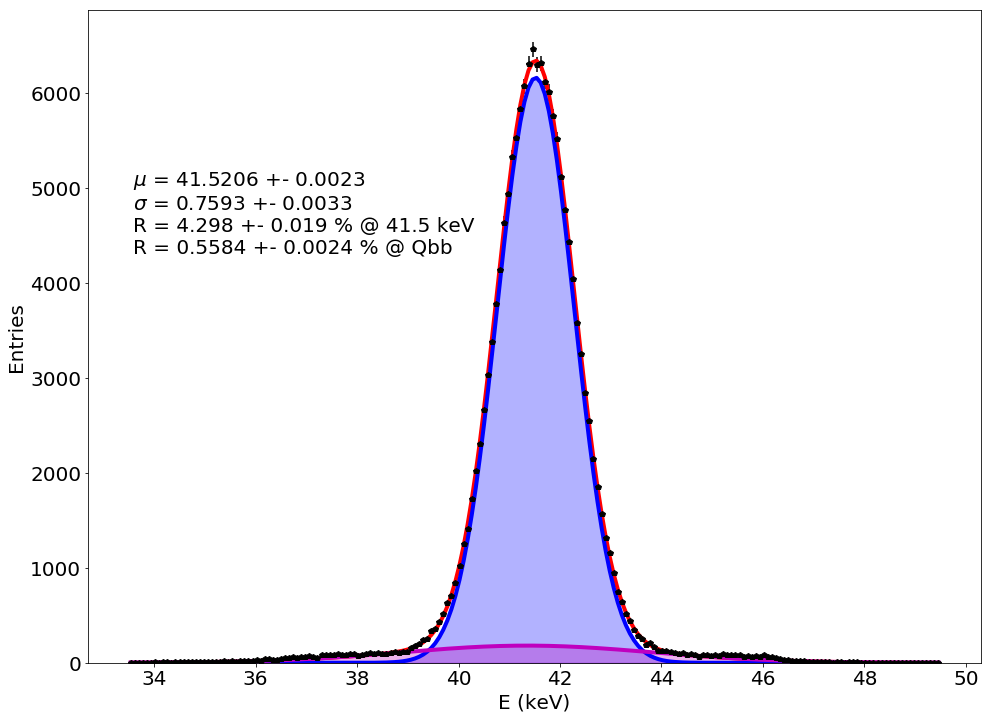

In [12]:
sel_r = coref.in_range(R, 0, R_fiducial)
data  = measure_resolution(E[sel_r], bkg=fitf.gauss)

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot        (x, data.f.fn (x)                     , lw=global_linewidth, color=global_linecolor   )
plt.plot        (x, fitf.gauss(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
plt.fill_between(x, fitf.gauss(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
plt.plot        (x, fitf.gauss(x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
plt.fill_between(x, fitf.gauss(x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])

plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
         max(data.xy.y) / 1.5,
         gausstext(data.f.values, data.f.errors, 41.5))


plt.ylim(0)
labels("E (keV)", "Entries", f"Energy spectrum for R < {R_fiducial:.0f} mm")
save("EnergySpectrumFiducialR")

Resolution at 41.5 keV: 3.987 +- 0.027
Resolution at 2458 keV: 0.5181 +- 0.0035
Chi2                  : 0.863382120396


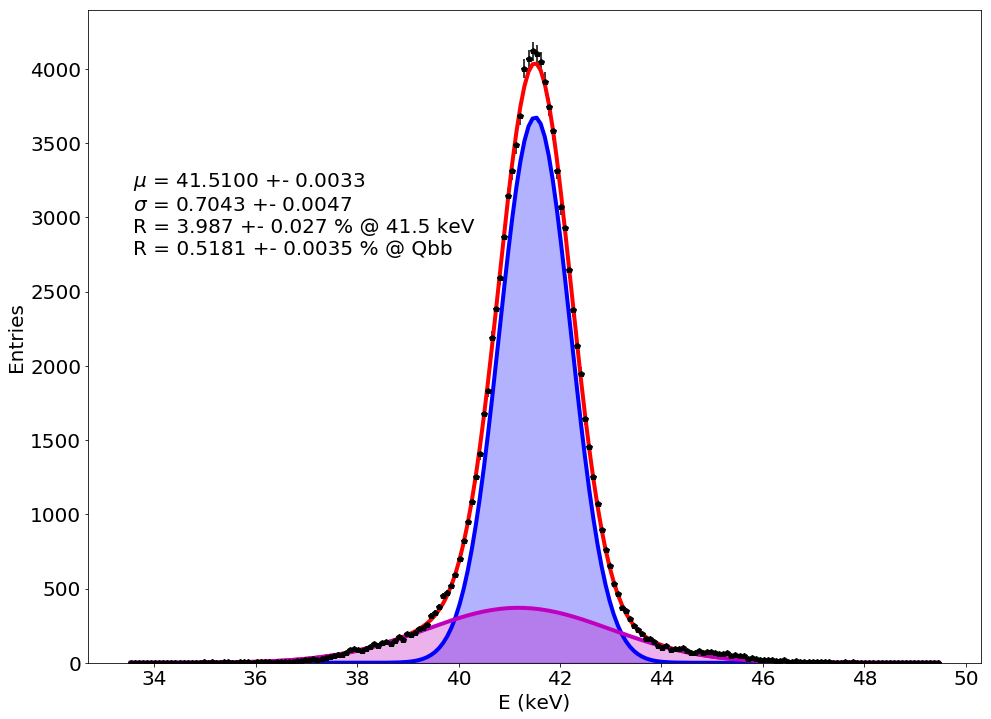

In [13]:
sel_z = coref.in_range(Z, 0, Z_fiducial)
data  = measure_resolution(E[sel_z], bkg=fitf.gauss)

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot        (x, data.f.fn (x)                     , lw=global_linewidth, color=global_linecolor   )
plt.plot        (x, fitf.gauss(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
plt.fill_between(x, fitf.gauss(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
plt.plot        (x, fitf.gauss(x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
plt.fill_between(x, fitf.gauss(x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])
plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
         max(data.xy.y) / 1.5,
         gausstext(data.f.values, data.f.errors, 41.5))


plt.ylim(0)
labels("E (keV)", "Entries", f"Energy spectrum for Z < {Z_fiducial:.0f} µs")
save("EnergySpectrumFiducialZ")

Resolution at 41.5 keV: 3.711 +- 0.046
Resolution at 2458 keV: 0.4821 +- 0.0060
Chi2                  : 0.961779653642


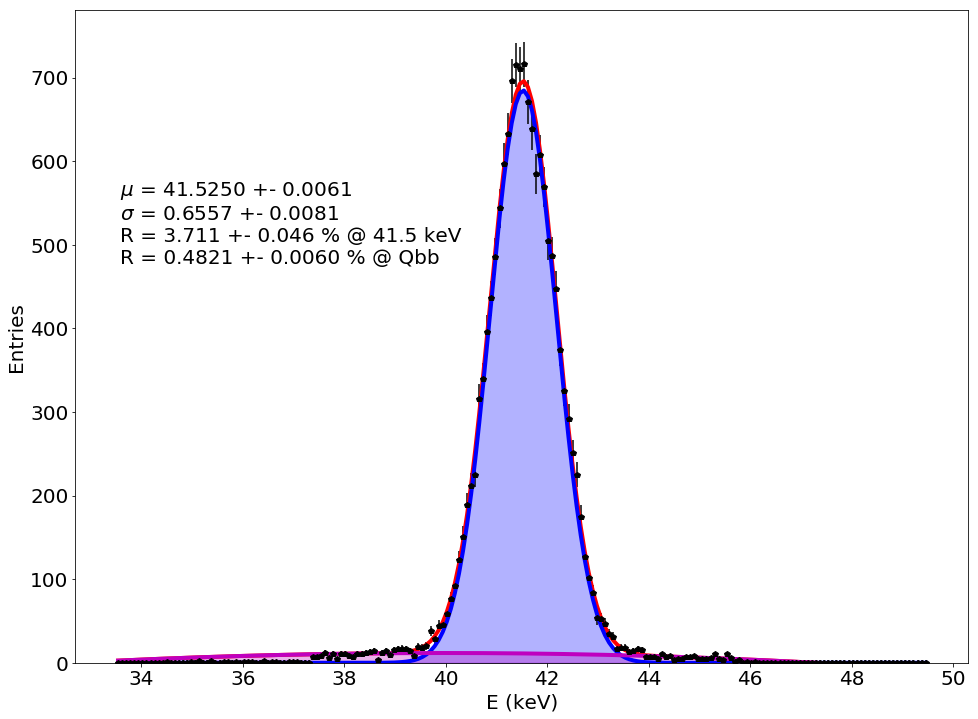

In [14]:
sel_r = coref.in_range(R, 0, R_fiducial)
sel_z = coref.in_range(Z, 0, Z_fiducial)
data  = measure_resolution(E[sel_r & sel_z], bkg=fitf.polynom)

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot        (x, data.f.fn   (x)                     , lw=global_linewidth, color=global_linecolor   )
plt.plot        (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
plt.fill_between(x, fitf.gauss  (x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
plt.plot        (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
plt.fill_between(x, fitf.polynom(x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])
plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
         max(data.xy.y) / 1.5,
         gausstext(data.f.values, data.f.errors, 41.5))


plt.ylim(0)
labels("E (keV)", "Entries", f"Energy spectrum for R < {R_fiducial:.0f} mm, Z < {Z_fiducial:.0f} µs")
save("EnergySpectrumFiducialRZ")

Z in [46.7, 93.3) mm
| Resolution at 2458 keV: 0.4807 +- 0.0064
| Chi2                  : 1.02136769061
Z in [93.3, 140.0) mm
| Resolution at 2458 keV: 0.5072 +- 0.0057
| Chi2                  : 0.857593965723
Z in [140.0, 186.7) mm
| Resolution at 2458 keV: 0.5307 +- 0.0058
| Chi2                  : 1.09991228374
Z in [186.7, 233.3) mm
| Resolution at 2458 keV: 0.5404 +- 0.0059
| Chi2                  : 0.865135595902
Z in [233.3, 280.0) mm
| Resolution at 2458 keV: 0.5531 +- 0.0059
| Chi2                  : 1.07572850925
Z in [280.0, 326.7) mm
| Resolution at 2458 keV: 0.5660 +- 0.0063
| Chi2                  : 1.19020117945
Z in [326.7, 373.3) mm
| Resolution at 2458 keV: 0.5910 +- 0.0069
| Chi2                  : 0.691644963169
Z in [373.3, 420.0) mm
| Resolution at 2458 keV: 0.6179 +- 0.0075
| Chi2                  : 0.812620172604
Z in [420.0, 466.7) mm
| Resolution at 2458 keV: 0.6094 +- 0.0079
| Chi2                  : 1.02381246889
Z in [466.7, 513.3) mm
| Resolution at 2458 k

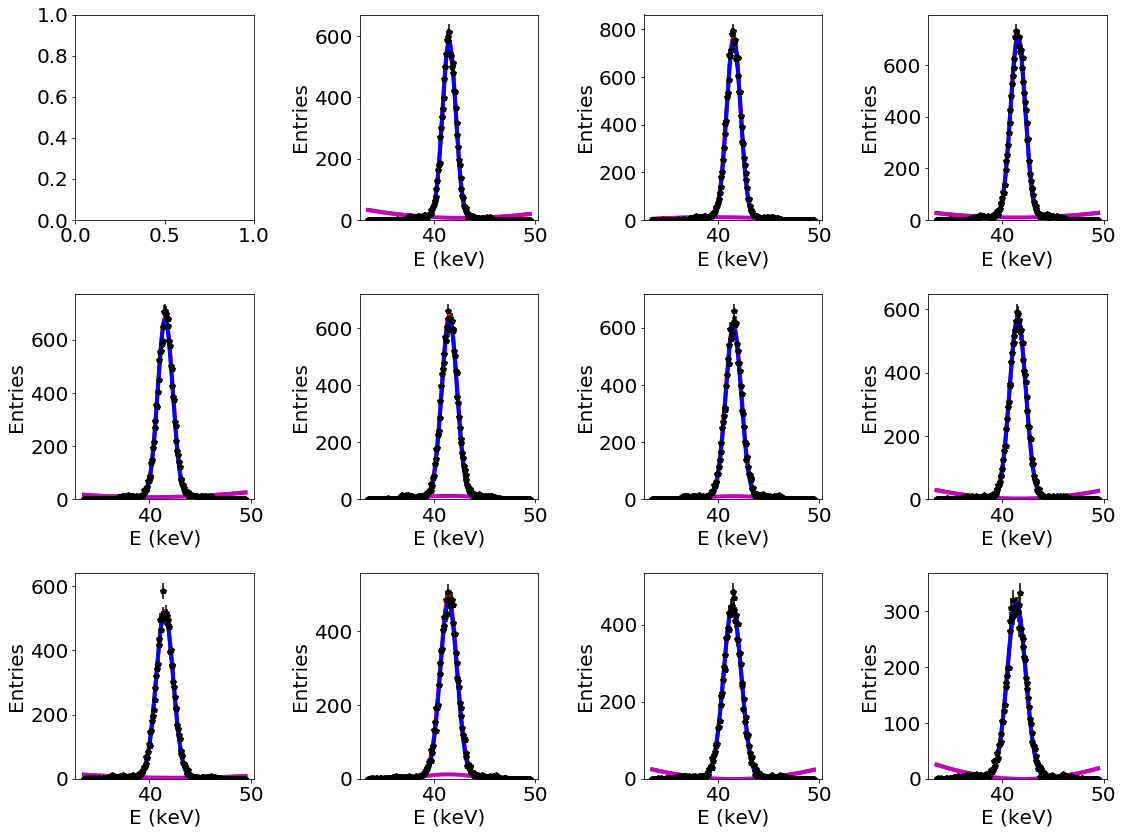

In [15]:
zbins = np.linspace(*Zrange, 13)
nbins = len(zbins) - 1
z     = shift_to_bin_centers(zbins)
dz    = 0.5 * np.diff       (zbins)

valid         = np.zeros(nbins, dtype=bool     )
Chi2          = np.zeros(nbins, dtype=np.double)
Resolution    = np.zeros(nbins, dtype=np.double)
Resolutionu   = np.zeros(nbins, dtype=np.double)
ResolutionBB  = np.zeros(nbins, dtype=np.double)
ResolutionBBu = np.zeros(nbins, dtype=np.double)

sel_r = coref.in_range(R, 0, R_fiducial)
for i in range(nbins):
    plt.subplot(3, 4, i+1)
    try:
        zmin, zmax = zbins[i:i+2]
        sel_z = coref.in_range(Z, zmin, zmax)
        sel   = sel_r & sel_z
        if np.count_nonzero(sel) < 100: continue

        data  = measure_resolution(E[sel], bkg=fitf.polynom)

        print(f"Z in [{zmin:.1f}, {zmax:.1f}) mm")
        print( "| Resolution at 2458 keV:", measurement_string(*data.R[1]))
        print( "| Chi2                  :", data.f.chi2)

        x = data.xy.x
        plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
        plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
        plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
        plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])

        plt.ylim(0)
        labels("E (keV)", "Entries", f"Z $\in$ [{zmin:.1f}, {zmax:.1f}) mm")

        Resolution  [i], Resolutionu  [i] = data.R[0]
        ResolutionBB[i], ResolutionBBu[i] = data.R[1]
        Chi2        [i]                   = data.f.chi2
        valid       [i]                   = True
    except:
        pass

plt.tight_layout()
save("ResolutionZslices")

[  4.35455990e-02   1.17825770e+03   3.56502097e+00]
[  3.97017831e-02   8.62801458e+02   6.70515373e-02]


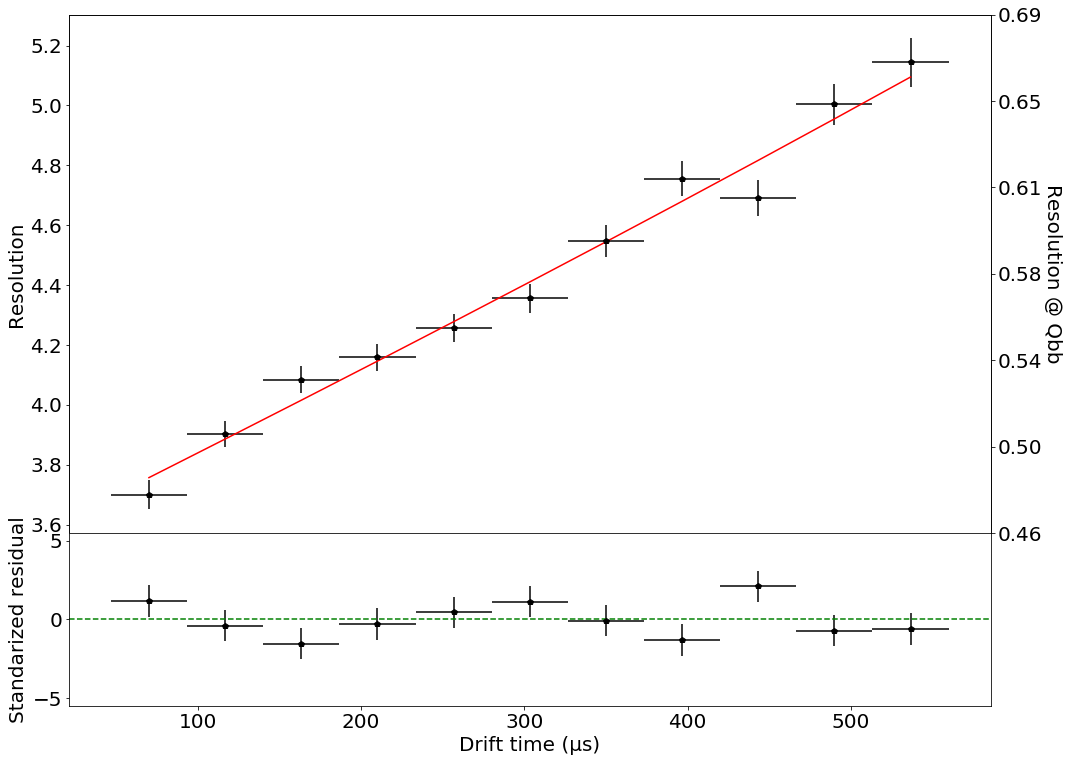

In [16]:
zz = z          [valid]
dd = dz         [valid]
rr = Resolution [valid]
uu = Resolutionu[valid]

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
plt.errorbar(zz, rr, uu, dd, "kp")
p_at = lambda x, LT: 1 - fitf.expo(-x, 1, LT)
s_at = lambda x, LT, ne: np.sqrt(p_at(x, LT)/(1 - p_at(x, LT))/ne)
f_at = lambda x, ne, LT, r0: (r0**2 + s_at(x, LT, ne)**2)**0.5

seed = 1800, 1800, 3.5
low  = 0, 0, 0
upp  = 1e6, 1e6, 5
#plt.plot(zz, s_at(zz, *seed), "m-")

#plt.plot(zz, s_at(zz, 1800, 1800, 3.58), "m-")
f = fitf.fit(f_at, zz, rr, seed, sigma=uu, bounds=(low, upp))
residuals = (f.fn(zz) - rr) / uu

plt.plot(zz, f.fn(zz), "r-")

#labels("Drift time (µs)", "Resolution", "Resolution vs Z")
labels("", "Resolution", "Resolution vs Z")


new_lims  = [lim * (41.5 / 2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution @ Qbb", rotation=-90, labelpad=20);

frame_data.set_xticklabels([])
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(zz, residuals, 1, np.diff(zz)[0]/2, fmt="p", c="k")
plt.plot    (lims, [0,0], "g--")
plt.xlim(*lims)
plt.ylim(-5.5, 5.5)
labels("Drift time (µs)", "Standarized residual")

print(f.values)
print(f.errors)

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


[ 40.48678169   3.48463159]
[ 1.67929774  0.03990318]


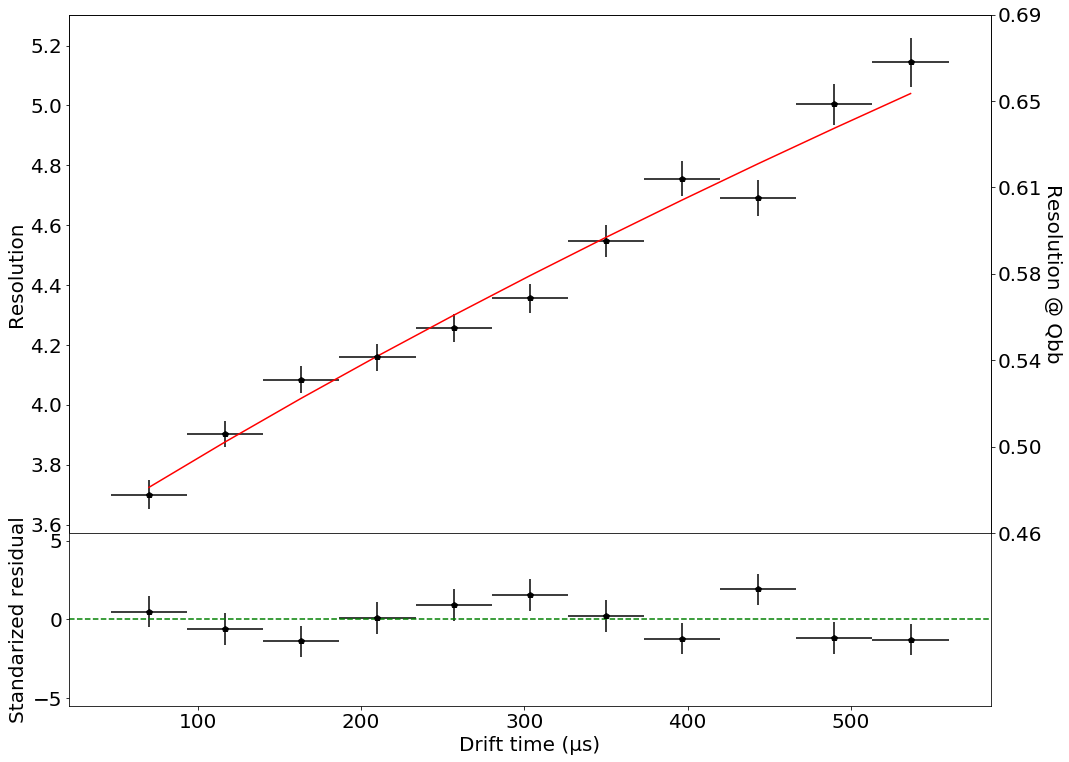

In [27]:
zz = z          [valid]
dd = dz         [valid]
rr = Resolution [valid]
uu = Resolutionu[valid]

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
plt.errorbar(zz, rr, uu, dd, "kp")
s_at = lambda x, LT: np.sqrt(x/LT)#*(1 - x/LT))
f_at = lambda x, LT, r0: (r0**2 + s_at(x, LT)**2)**0.5

seed = 1800, 3.5
#low  = 0, 0, 0
#upp  = 1e6, 1e6, 5
#plt.plot(zz, s_at(zz, *seed), "m-")

#plt.plot(zz, f_at(zz, 1800e3, 1800e3, 3.58), "m-")
f = fitf.fit(f_at, zz, rr, seed, sigma=uu, maxfev=10000)
residuals = (f.fn(zz) - rr) / uu

plt.plot(zz, f.fn(zz), "r-")

#labels("Drift time (µs)", "Resolution", "Resolution vs Z")
labels("", "Resolution", "Resolution vs Z")


new_lims  = [lim * (41.5 / 2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution @ Qbb", rotation=-90, labelpad=20);

frame_data.set_xticklabels([])
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(zz, residuals, 1, np.diff(zz)[0]/2, fmt="p", c="k")
plt.plot    (lims, [0,0], "g--")
plt.xlim(*lims)
plt.ylim(-5.5, 5.5)
labels("Drift time (µs)", "Standarized residual")

print(f.values)
print(f.errors)